# WASP-127b: Fitting only RVs

In [1]:
import numpy as np
import CONAN
import matplotlib.pyplot as plt
import pandas as pd
CONAN.__version__

'3.3.11'

In [ ]:
from CONAN.get_files import get_parameters

sys_params = get_parameters(planet_name="WASP-127b")
sys_params

## Setup RV

The RV setup is similar to the LC

In [3]:
path ="../data/"
rv_list = ["rv1.dat","rv2.dat"]    #rv data in km/s

In [6]:
rv_obj = CONAN.load_rvs(file_list     = rv_list, 
                         data_filepath = path,
                         rv_unit       ='km/s',
                         nplanet       = 1,
                        )
rv_obj

Linking the last created lightcurve object to the rv object for parameter linking. if this is not the related LC object, input the correct one using `lc_obj` argument of `load_rvs()`
.
# ============ Input RV curves, baseline function, GP, spline,  gamma ============================================ 
name    RVunit scl_col |col0 col3 col4 col5| sin GP spline_config   | gamma_km/s     
rv1.dat km/s   None    |   0    0    0    0|   0 n  None            | F(0.0)        
rv2.dat km/s   None    |   0    0    0    0|   0 n  None            | F(0.0)        


rvs from filepath: ../data/
1 planet(s)

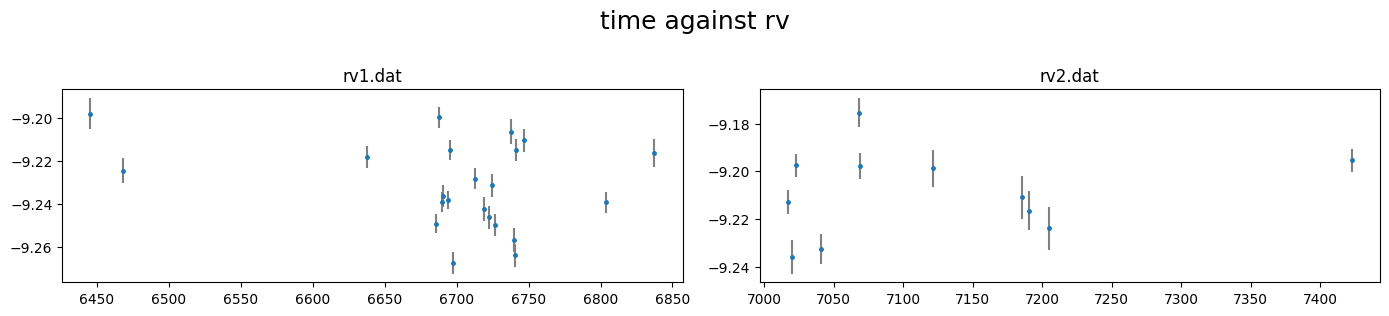

In [7]:
rv_obj.plot()

In [8]:
rv_obj.rescale_data_columns()

Rescaled data columns of rv1.dat with method:med_sub
Rescaled data columns of rv2.dat with method:med_sub


### Baseline and decorrelation

- similar to lightcurves, we can manually specify the rv baseline model using the `.rv_baseline()` method

In [9]:
rv_obj.rv_baseline( dcol0 = None,
                    dcol3 = None,
                    dcol4 = None,
                    dcol5 = None,
                    gamma = [(-9.232,0.1),    #systemic velocity rv1
                             (-9.21,0.1)],    #systemic velocity rv2
                    )

# ============ Input RV curves, baseline function, GP, spline,  gamma ============================================ 
name    RVunit scl_col |col0 col3 col4 col5| sin GP spline_config   | gamma_km/s     
rv1.dat km/s   med_sub |   0    0    0    0|   0 n  None            | N(-9.232,0.1) 
rv2.dat km/s   med_sub |   0    0    0    0|   0 n  None            | N(-9.21,0.1)  


- or we can use the `.get_decorr()` method to find the best decorrelation. 

By setting `setup_planet=True` the planet parameter priors are also passed to the `planet_parameters()` and we dont need to do that again, unless we wish to change the priors


getting decorr params for rv01: rv1.dat (jitt=0.00km/s)

BEST BIC:85.63, pars:['B0']

getting decorr params for rv02: rv2.dat (jitt=0.00km/s)

BEST BIC:14.02, pars:[]
Setting-up rv baseline model from result
# ============ Input RV curves, baseline function, GP, spline,  gamma ============================================ 
name    RVunit scl_col |col0 col3 col4 col5| sin GP spline_config   | gamma_km/s     
rv1.dat km/s   med_sub |   2    0    0    0|   0 n  None            | N(-9.233510019201736,0.1)
rv2.dat km/s   med_sub |   0    0    0    0|   0 n  None            | N(-9.210554832954267,0.1)

Setting-up planet RV pars from input values
# ============ Planet parameters (Transit and RV) setup ========================================================== 
name                       fit 	prior                              	note
[rho_star]/Duration        n   	F(0)                               	#choice in []|unit(gcm^-3/days)
--------repeat this line & params below for multisystem, adding

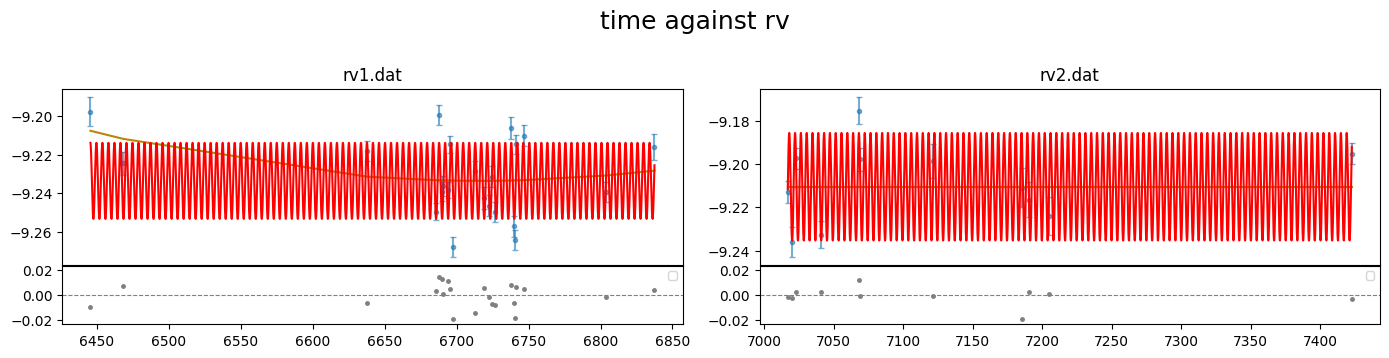

In [10]:
t0  = sys_params["planet"]["T0"][0] - 2450000
P   = sys_params["planet"]["period"][0]

rvdecorr_res= rv_obj.get_decorr(T_0           = t0,     #fixed
                                Period        = P,      #fixed                 
                                Eccentricity  = 0,
                                omega         = 90,
                                K             = (0,10e-3,100e-3),     #km/s
                                gamma        = (-9.21,0.1),
                                delta_BIC    = -5,
                                setup_planet = True)


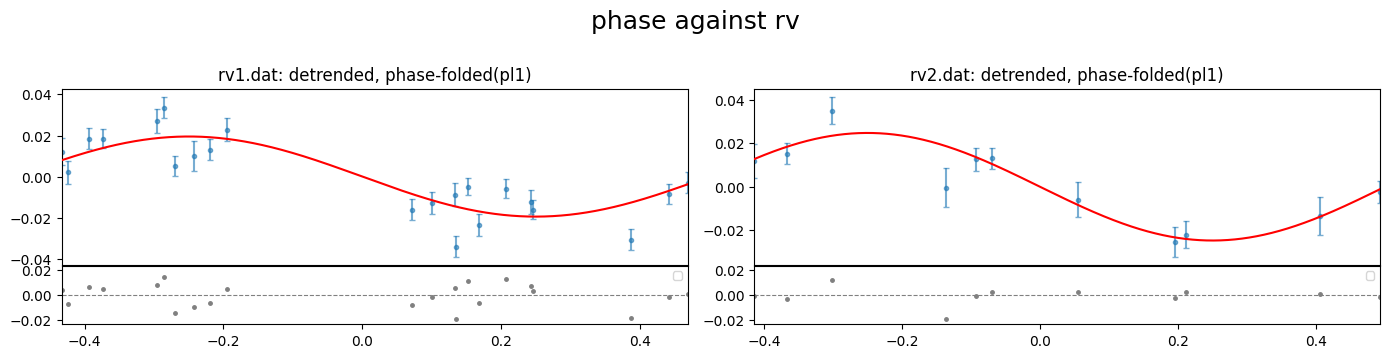

In [11]:
rv_obj.plot(detrend=True, show_decorr_model=True, phase_plot=1)

## Setup Sampling

finally to setup the `fit_obj` which is used to configure the fitting.

We can specify values for the stellar mass or radius to be used to convert parameter results to physical values. These values are not used in the fit, only for the post-fit conversion. The values from our NASA archive `sys_params` dictionary

In [12]:
sys_params["star"]["radius"], sys_params["star"]["mass"]

((1.333, 0.027), (0.95, 0.02))

setup sampling using the `.sampling()` method of `fit_obj`. Note that the sampling of the parameter space can be done with `emcee` or `dynesty`. The default is `dynesty`

In [13]:
fit_obj = CONAN.fit_setup( M_st = sys_params["star"]["mass"],
                            par_input = "Mrho",
                            apply_RVjitter="y",
                            verbose=False)

fit_obj.sampling(sampler="dynesty",n_cpus=10, n_live=100, verbose=False)

## Export configuration

All configuration can be exported to a `config.dat` file that allows to reproduce all steps and eventually run the fit

In [13]:
CONAN.create_configfile(None, rv_obj, fit_obj,
                         filename='wasp127_rv_config.dat')

configuration file saved as wasp127_rv_config.dat


In [14]:
# #reload objects from config file
# import CONAN
# lc_obj, rv_obj, fit_obj = CONAN.load_configfile('wasp127_rv_config.dat')

## Sampling

Finally perform the **fitting** which returns a result object `result_obj` that holds the chains of the mcmc and allows subsequent plotting.

The result of the fit is saved to a user-defined folder (default = 'output'). If a fit result already exists in this folder, it is loaded to the `result_obj`

In [ ]:
result = CONAN.run_fit(lc_obj  = None,
                        rv_obj  = rv_obj,
                        fit_obj = fit_obj,
                        out_folder="result_wasp127_rv_fit",
                        rerun_result=True);

## Results

In [17]:
import CONAN
import matplotlib.pyplot as plt
from CONAN.utils import bin_data, phase_fold

In [18]:
result =CONAN.load_result(folder="result_wasp127_rv_fit")
result

['lc'] Output files, [], loaded into result object
['rv'] Output files, ['rv1_rvout.dat', 'rv2_rvout.dat'], loaded into result object


Object containing posterior from emcee/dynesty sampling                 
Parameters in chain are:
	 ['K', 'rv1_gamma', 'rv1_jitter', 'rv2_gamma', 'rv2_jitter', 'rv1_A0', 'rv1_B0']                 

use `plot_chains()`, `plot_burnin_chains()`, `plot_corner()` or `plot_posterior()` methods on selected parameters to visualize results.

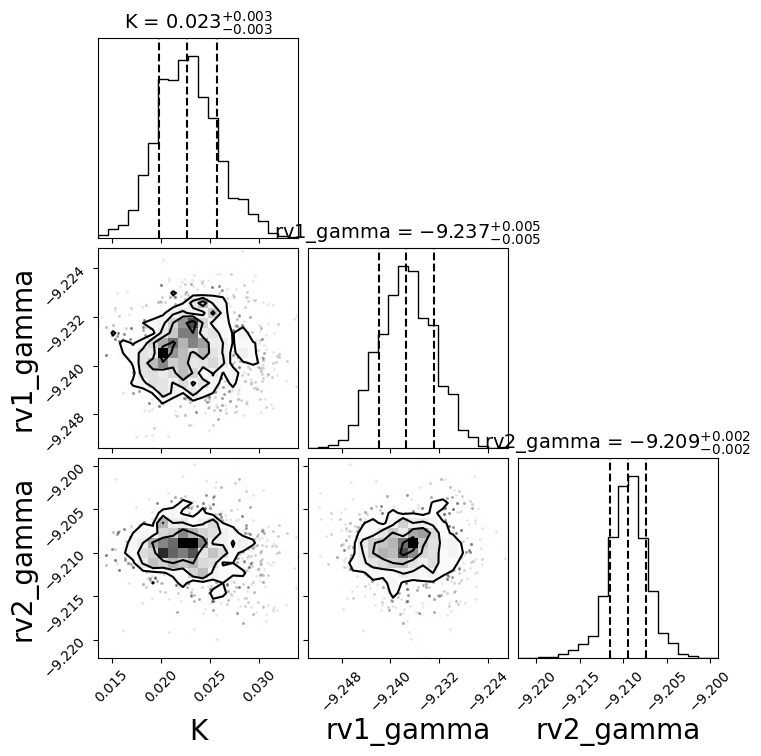

In [20]:
fig = result.plot_corner(pars =['K','rv1_gamma','rv2_gamma']);

### RVs

In [21]:
result.rv.names

['rv1.dat', 'rv2.dat']

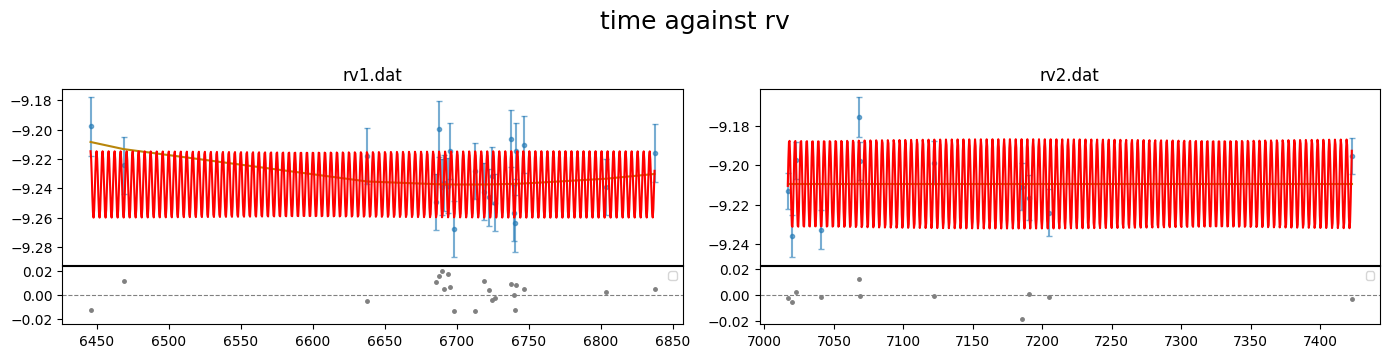

In [22]:
fig = result.rv.plot_bestfit()

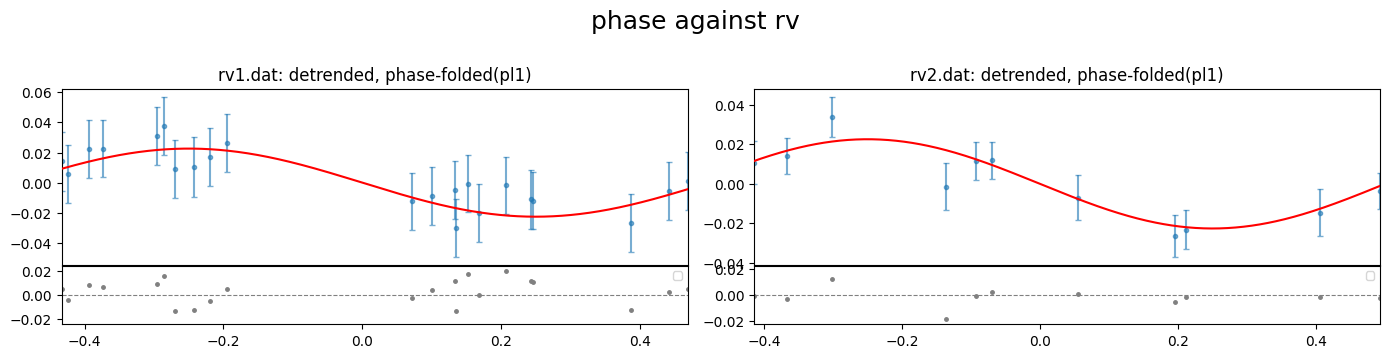

In [23]:
result.rv.plot_bestfit(detrend=True, phase_plot=1);

In [24]:
#load output data files for the rv fits
rv1data = result.rv.outdata['rv1.dat']
rv2data = result.rv.outdata['rv2.dat']

In [25]:
#evaluate RV model on a smoother time array
t_sm  = np.linspace(rv1data["time"].min(), rv1data["time"].max(), 1000)
rvmod = result.rv.evaluate(file="rv1.dat",time=t_sm, return_std=True)

phases = phase_fold(t=t_sm, per=result.params.P, 
                    t0=result.params.T0, phase0=-0.5)
#sort
srt    = np.argsort(phases)

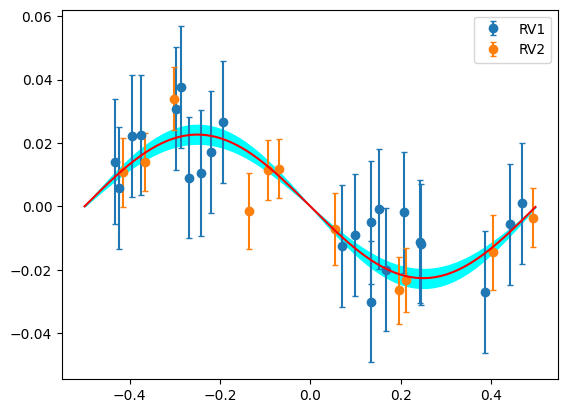

In [26]:
plt.errorbar(rv1data["phase"],rv1data["det_RV"],rv1data["error"],fmt="o",capsize=2,label="RV1")
plt.errorbar(rv2data["phase"],rv2data["det_RV"],rv2data["error"],fmt="o",capsize=2,label="RV2")

plt.plot(phases[srt], rvmod.planet_model[srt],"r",zorder=5)

plt.fill_between(phases[srt],rvmod.sigma_low[srt], rvmod.sigma_high[srt], color="cyan")


plt.legend()